The Copernicus digital elevation model is derived from the WorldDEMTM digital surface model based on the radar satellite data acquired during the TanDEM-X Mission. The Planetary Computer hosts these data as Cloud Optimized GeoTIFFs in two resolutions, 90m and 30m.

For this example, we will find the DEM tile that includes the Grand Canyon and plot the elevation data with some hillshade.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import odc.stac
import geopandas as gpd
import geopy.distance as distance
from shapely.geometry import Point
import rioxarray 
import xarray
import rasterio
import matplotlib.pyplot as plt
from rasterio import plot
import geopandas as gpd
from shapely.geometry import box
import datashader
import cv2
from tqdm import tqdm
%matplotlib inline

In [2]:
# get path to the data folder
DATA_DIR = Path.cwd().parent.resolve() / "data"
assert DATA_DIR.exists()

In [3]:
# read .csv files
train_labels = pd.read_csv(DATA_DIR / "train_labels.csv")
submission_format = pd.read_csv(DATA_DIR / "submission_format.csv", index_col=0)
metadata = pd.read_csv(DATA_DIR / "metadata.csv")
#metadata.head()

In [4]:
dataset = metadata.merge(train_labels, on='uid', how='inner')
dataset.sort_values('density', ascending=False).head(5)

uid  latitude  longitude        date  split   region  severity  \
7843   lvtt  39.21067  -96.97298  2015-10-05  train  midwest         5   
13853  vbvq  38.38889  -97.09306  2013-06-10  train  midwest         5   
16198  yqgb  39.21155  -97.00559  2014-09-22  train  midwest         5   
12797  tlfq  39.21067  -96.97298  2015-07-13  train  midwest         5   
4287   gnlr  43.32937 -108.15619  2021-08-17  train     west         5   

            density  
7843   8.046675e+08  
13853  1.959300e+08  
16198  9.127360e+07  
12797  7.660800e+07  
4287   7.181390e+07

In [5]:
dataset.shape

(17060, 8)

In [6]:
example_row = metadata[metadata.uid == "dzwu"].iloc[0]
example_row

uid                dzwu
latitude       40.40586
longitude        -76.08
date         2019-07-16
split             train
Name: 3639, dtype: object

 find the DEM tile that includes the Grand Canyon and plot the elevation data with some hillshade.

In [7]:
#find the DEM tile that includes the selected coordinates and plot the elevation data with some hillshade.
import pystac_client
import planetary_computer

copernicus_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [8]:
#Perform a STAC API query against the finer resolution cop-dem-glo-30 collection for our point of interest.
search = copernicus_catalog.search(
    collections=["cop-dem-glo-30"],
    intersects={"type": "Point", "coordinates":  [example_row.longitude,example_row.latitude, ]},
)
items = list(search.get_items())
print(f"Returned {len(items)} items")

Returned 1 items


A single item was returned which includes the elevation data and additional assets for quick visualization.

In [9]:
list(items[0].assets)

['data', 'tilejson', 'rendered_preview']

In [10]:
items[0]


<Item id=Copernicus_DSM_COG_10_N40_00_W077_00_DEM>

In [11]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

print(f"Filtering from {len(item_details)} returned to {item_details.sum()} items that contain the sample location")
item_details[["datetime", "platform", "bbox"]].sort_values(by="datetime")


Filtering from 1 returned to datetime                                           2021-04-22
platform                                             TanDEM-X
min_long                                           -77.000139
max_long                                           -76.000139
min_lat                                             40.000139
max_lat                                             41.000139
bbox        [-77.00013888888888, 40.00013888888889, -76.00...
item_obj    <Item id=Copernicus_DSM_COG_10_N40_00_W077_00_...
dtype: object items that contain the sample location


datetime  platform                                               bbox
0  2021-04-22  TanDEM-X  [-77.00013888888888, 40.00013888888889, -76.00...

In [12]:
# load the tile into an xarray after signing the HREF using planetary_computer.sign. Here we are downsampling the data to reduce the image size for this notebook.

import planetary_computer
import rioxarray

signed_asset = planetary_computer.sign(items[0].assets["data"])
data = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5})
    .mean()
)

With the data loaded, we can use xarray-spatial to generate a shaded relief.

In [13]:
import xrspatial
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation

hillshade = xrspatial.hillshade(data)
stack(shade(hillshade, cmap=["white", "gray"]), shade(data, cmap=Elevation, alpha=128))

In [14]:
# flip the plot on y axis
hillshade = xrspatial.hillshade(data)
stack(shade(hillshade, cmap=["white", "gray"]), shade(data[::-1, :], cmap=Elevation, alpha=128))

In [15]:
import matplotlib.pyplot as plt

# Plot the hillshade
plt.imshow(hillshade, origin='lower', cmap='gray')

# Add a colorbar
plt.colorbar()

# Add x,y axis labels and units
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')

# Add a buffer of 100 meters on each axis
plt.xlim(100, hillshade.shape[1]-100)
plt.ylim(100, hillshade.shape[0]-100)
# this flip the plot on y axis 
plt.gca().invert_yaxis()
# this flip the plot on x axis 
#plt.gca().invert_xaxis()
# Show the plot
plt.show()

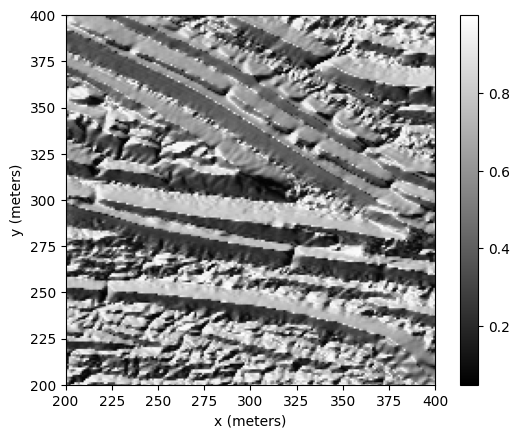

In [16]:
import matplotlib.pyplot as plt

# Plot the hillshade
plt.imshow(hillshade, origin='lower', cmap='gray')

# Add a colorbar
plt.colorbar()

# Add x,y axis labels and units
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')

# Add a buffer of 100 meters on each axis
plt.xlim(100, hillshade.shape[1]-100)
plt.ylim(100, hillshade.shape[0]-100)
plt.gca().invert_yaxis()
plt.xlim(200, 400)
plt.ylim(200, 400)


# Show the plot
plt.show()

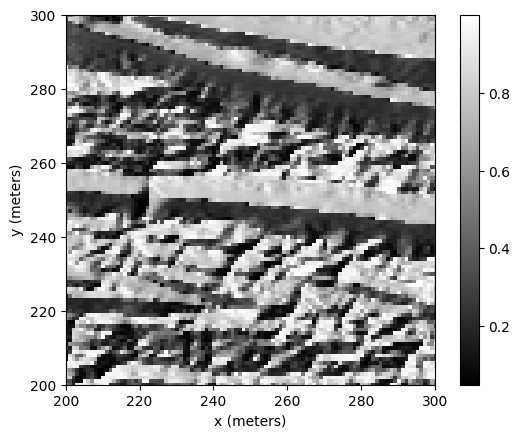

In [17]:
import matplotlib.pyplot as plt

# Plot the hillshade
plt.imshow(hillshade, origin='lower', cmap='gray')

# Add a colorbar
plt.colorbar()

# Add x,y axis labels and units
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')

# Add a buffer of 100 meters on each axis
plt.xlim(100, hillshade.shape[1]-100)
plt.ylim(100, hillshade.shape[0]-100)
plt.gca().invert_yaxis()
plt.xlim(200, 300)
plt.ylim(200, 300)


# Show the plot
plt.show()

In [18]:
data.plot()

In [19]:
data.plot()

In [20]:
#function that takes the latitude and longitude coordinates of a location and returns location_url
def get_location_url_google_maps(latitude, longitude):
    return "https://www.google.com/maps/search/?api=1&query=" + str(latitude) + "," + str(longitude)

location_url = get_location_url_google_maps(example_row.latitude,example_row.longitude)

print(location_url)

https://www.google.com/maps/search/?api=1&query=40.40586,-76.08


Location range: We'll search an area with 50,000 meters on our either side of our sample point (100,000 m x 100,000 m), to make sure we're pulling in all relevant imagery. This is just a starting point, and you can improve on how to best search for the correct location in the Planetary Computer.

In [21]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=50000)
bbox

[-76.66901558184789, 39.95556414455407, -75.49098441815211, 40.85612067942069]

In [22]:
signed_asset = planetary_computer.sign(items[0].assets["data"])
data = (
    rioxarray.open_rasterio(signed_asset.href).rio.clip_box(
        minx=bbox[0],
        miny=bbox[1],
        maxx=bbox[2],
        maxy=bbox[3],
        crs="EPSG:4326",
    ).squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5 }, boundary='pad')
    .mean()
)

In [23]:
def crop_copernicus_image(item, bounding_box):
    """
    Given a STAC item from copernicus and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(planetary_computer.sign(item.assets["data"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [24]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(example_row.latitude,example_row.longitude, meter_buffer=635)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_copernicus_image(items[0], bbox)

zoomed_img_array[0]

array([[ 89.5     ,  89.72498 ,  90.21536 , ..., 129.18405 , 129.74084 ,
        128.96964 ],
       [ 90.5352  ,  92.15963 ,  92.871445, ..., 127.914055, 128.42377 ,
        127.896126],
       [ 90.75471 ,  92.62975 ,  92.8443  , ..., 126.34711 , 126.31189 ,
        126.68134 ],
       ...,
       [125.41613 , 126.27441 , 127.28193 , ..., 100.8322  , 100.55535 ,
         99.532646],
       [131.37193 , 131.03674 , 131.9768  , ...,  98.52973 ,  97.67468 ,
         96.88872 ],
       [142.10498 , 138.77817 , 135.96642 , ...,  95.144875,  95.32894 ,
         96.49285 ]], dtype=float32)

In [25]:
bbox

(-76.08748060859388, 40.40014146298525, -76.07251939140612, 40.41157853134108)

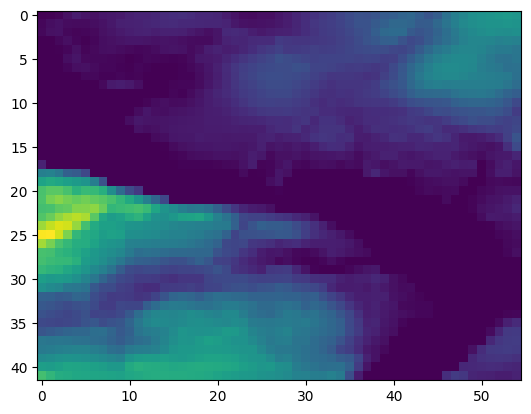

In [26]:
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2 , 0]), cmap='viridis')

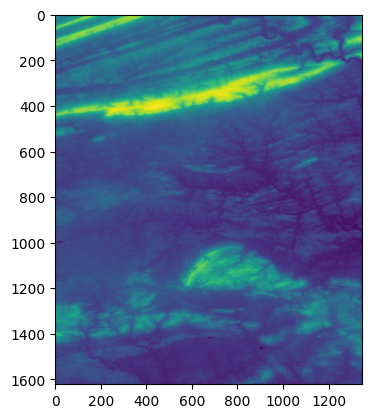

In [27]:
#for the presentation 
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(example_row.latitude,example_row.longitude, meter_buffer=25000)
# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_copernicus_image(items[0], bbox)
#zoomed_img_array[0]
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2 , 0]), cmap='viridis')

In [28]:
#for the presentation 
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(example_row.latitude,example_row.longitude, meter_buffer=12500)
# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_copernicus_image(items[0], bbox)
#zoomed_img_array[0]
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2 , 0]), cmap='viridis')

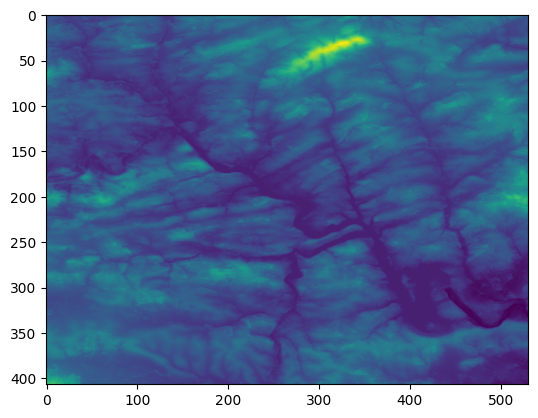

In [29]:
#for the presentation 
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(example_row.latitude,example_row.longitude, meter_buffer=6250)
# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_copernicus_image(items[0], bbox)
#zoomed_img_array[0]
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2 , 0]), cmap='viridis')

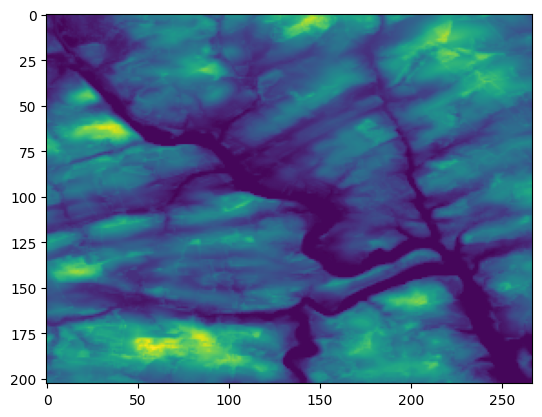

In [30]:
#for the presentation 
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(example_row.latitude,example_row.longitude, meter_buffer=3125)
# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_copernicus_image(items[0], bbox)
#zoomed_img_array[0]
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2 , 0]), cmap='viridis')

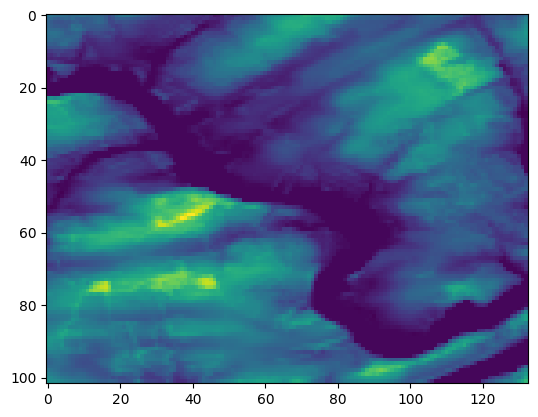

In [31]:
#for the presentation 
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(example_row.latitude,example_row.longitude, meter_buffer=1560)
# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_copernicus_image(items[0], bbox)
#zoomed_img_array[0]
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2 , 0]), cmap='viridis')

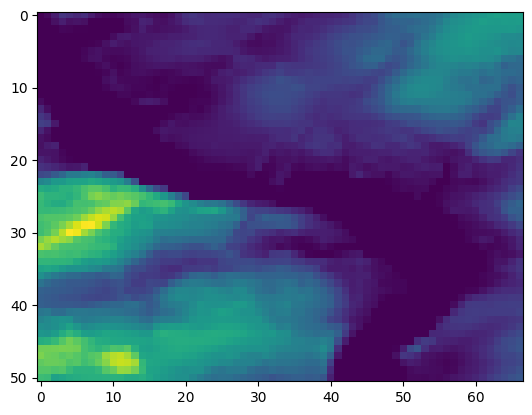

In [32]:
#for the presentation 
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(example_row.latitude,example_row.longitude, meter_buffer=780)
# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_copernicus_image(items[0], bbox)
#zoomed_img_array[0]
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2 , 0]), cmap='viridis')

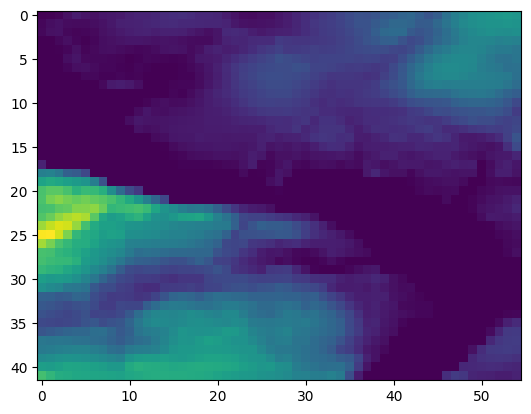

In [33]:
#for the presentation 
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(example_row.latitude,example_row.longitude, meter_buffer=635)
# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_copernicus_image(items[0], bbox)
#zoomed_img_array[0]
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2 , 0]), cmap='viridis')

In [34]:
zoomed_img_array.shape

(1, 42, 55)

In [35]:
zoomed_img_array.min(), zoomed_img_array.max()

(89.2152, 164.62407)

In [36]:
def normalize_elevation(arr):
    ''' Function to scale an input array to [0.0, 1.0] '''
    arr_min = -100 # lowest point: death valley
    arr_max = 4500 # highest point
    
    arr_range = arr_max - arr_min
    scaled = np.array((arr-arr_min) / float(arr_range), dtype='f')
    
    # limit values to 1.0
    scaled[scaled >= 1.0] = 1.0
    arr_new = ( (scaled)) 
    return arr_new

In [37]:
# scale pixel values into practical range
normalized = normalize_elevation(zoomed_img_array[0])
# upscale landsat images to same pixel size as sentinel
elevation_layer = np.array([cv2.resize(normalized, ( 128, 128), interpolation = cv2.INTER_AREA)])

In [38]:
elevation_layer.shape, elevation_layer.min(), elevation_layer.max()

((1, 128, 128), 0.041133743, 0.057526976)

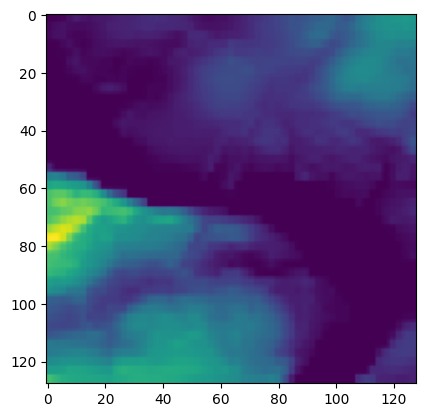

In [39]:
plt.imshow(np.transpose((elevation_layer), axes=[1, 2, 0]),cmap='viridis')

In [40]:
#To plot the location on a map 
#import folium
#from IPython.display import display
#
#def plot_location_on_map(latitude, longitude):
#    m = folium.Map(location=[latitude, longitude], zoom_start=12)
#    folium.Marker([latitude, longitude]).add_to(m)
#    display(m)
#
#plot_location_on_map(41.9895, -110.6616)

# ********************

In [41]:
search = copernicus_catalog.search(
    collections=["cop-dem-glo-30"],
    intersects={"type": "Point", "coordinates":  [example_row.longitude,example_row.latitude, ]},
)
items = list(search.get_items())
print(f"Returned {len(items)} items")

Returned 1 items


In [42]:
from datetime import timedelta
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range

In [43]:
def collect_elevation_layers(row, copernicus_catalog, image_size=128, verbose=False):
    # Search in catalog based on bounding box and date
    # calculate rough estimate of the bounding box size based on copernicus resolution 10m/pixel
    meter_buffer = ((10 * image_size) / 2) - 5
    bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=meter_buffer)

    date_range = get_date_range(row.date, time_buffer_days=15)

    # search the planetary computer sentinel-l2a and landsat level-2 collections
    search_results = copernicus_catalog.search(
        collections=["cop-dem-glo-30"],
    intersects={"type": "Point", "coordinates":  [row.longitude,row.latitude, ]},
)

    # get details of all of the items returned
    items = [item for item in search_results.get_all_items()]
    item_details = pd.DataFrame([
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }

        for item in items])

    # check which rows actually contain the sample location
    item_details["contains_sample_point"] = (
    (item_details.min_lat < row.latitude)
    & (item_details.max_lat > row.latitude)
    & (item_details.min_long < row.longitude)
    & (item_details.max_long > row.longitude)
    )
    item_details = item_details[item_details["contains_sample_point"]]

    # check how many Sentinel and Landsat images are available
    num_copernicus = len(item_details[item_details.platform.str.contains("TanDEM-X")])
    if verbose:
        print(f"Datapoint ID: {row.uid}")
        print(f"Number of copernicus items found: {num_copernicus}")

    # collect layer from catalog (based on copernicus )
   
    if num_copernicus > 0:
        # If sentinel is available, it is first choice.
        if verbose: 
            print('TanDEM-X')
        # Select closest image by date.
        # TODO: Refine selection by using the less cloudy image when there's more than one image for the date??
        item = (
            item_details[item_details.platform.str.contains("TanDEM-X")]
            .sort_values(by="datetime", ascending=False)
            .iloc[0]
            ).item_obj
        # collect layers in dict
        
        image = rioxarray.open_rasterio(planetary_computer.sign(item.assets["data"].href)).rio.clip_box(
        minx=bbox[0],
        miny=bbox[1],
        maxx=bbox[2],
        maxy=bbox[3],
        crs="EPSG:4326",
    )
        # normalize pixel values into range 0.0 to 1.0
        normalized = normalize_elevation(image[0])
        # resize image if it does not match "image_size"
        if (normalized.shape[0] != image_size) or (normalized.shape[1] != image_size):
            #print(f'Shape {name}: {normalized.shape} -->RESIZED!!!')
            elevation_layer= cv2.resize(normalized, ( image_size, image_size), interpolation = cv2.INTER_AREA)
        else:
            elevation_layer = normalized
    else:
        # use array of zeros when no image is found
        if verbose:
            print("No Image was found!")
        elevation_layer = np.zeros([image_size, image_size])
    
    return elevation_layer

In [44]:
elevation_grid = collect_elevation_layers(example_row, copernicus_catalog, image_size=128, verbose=True)
elevation_grid 



Datapoint ID: dzwu
Number of copernicus items found: 1
TanDEM-X


array([[0.04119565, 0.04119565, 0.04122856, ..., 0.04988879, 0.04977601,
        0.04977601],
       [0.04119565, 0.04119565, 0.04122856, ..., 0.04988879, 0.04977601,
        0.04977601],
       [0.04119565, 0.04119565, 0.04122856, ..., 0.04988879, 0.04977601,
        0.04977601],
       ...,
       [0.05263152, 0.05263152, 0.05214499, ..., 0.04254562, 0.04271584,
        0.04271584],
       [0.05263152, 0.05263152, 0.05214499, ..., 0.04254562, 0.04271584,
        0.04271584],
       [0.05263152, 0.05263152, 0.05214499, ..., 0.04254562, 0.04271584,
        0.04271584]], dtype=float32)

In [45]:
elevation_grid.shape

(128, 128)

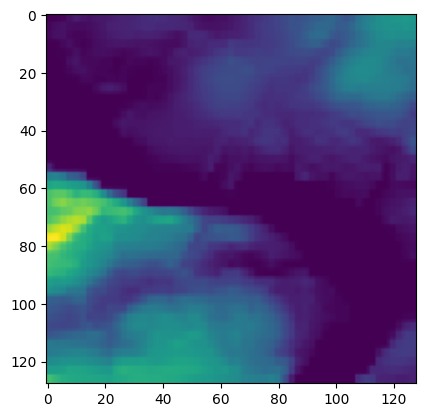

In [46]:
plt.imshow((elevation_grid),cmap='viridis')


### Download all satellite images of the dataset

In [47]:
BENCHMARK_DATA_DIR = DATA_DIR / "elevation"

# save image arrays in case we want to generate more features
ELEVATION_ARRAY_DIR = BENCHMARK_DATA_DIR / "elevation_1280_tiles"
ELEVATION_ARRAY_DIR.mkdir(exist_ok=True, parents=True)

In [48]:
ELEVATION_ARRAY_DIR / f"{example_row.uid}.npy"

PosixPath('/Users/marjangoudarzi/Neuefische/tick-tick-bloom/data/elevation/elevation_1280_tiles/dzwu.npy')

In [49]:
dataset.head()

uid   latitude  longitude        date  split   region  severity    density
0  aabm  39.080319 -86.430867  2018-05-14  train  midwest         1      585.0
1  aacd  35.875083 -78.878434  2020-11-19  train    south         1      290.0
2  aaee  35.487000 -79.062133  2016-08-24  train    south         1     1614.0
3  aaff  38.049471 -99.827001  2019-07-23  train  midwest         3   111825.0
4  aafl  39.474744 -86.898353  2021-08-23  train  midwest         4  2017313.0

## Downloading all images
* takes ~ [1:51:56 hours ,  2.54it/s] 
* requires ~1,12 GB 

In [50]:
# This cell takes a LONG time because it iterates over all data!

# save errored id's
errored_ids = []
#features_dict = {}
#for row in tqdm(dataset.head().itertuples(), total=len(dataset)): # the loop works just for the first row 
for row in tqdm(dataset.itertuples(), total=len(dataset)):
    # check if we've already saved the selected image array
    elevation_array_pth = ELEVATION_ARRAY_DIR / f"{row.uid}.npy"

    if elevation_array_pth.exists():
        with open(elevation_array_pth, "rb") as f:
            elevation_array = np.load(f)

        # # convert image to 1-dimensional features
        # image_features = image_to_features(image_array)
        # features_dict[row.uid] = image_features

    # search and load the image array if not
    else:
        try:
            elavation_layers = collect_elevation_layers(row, copernicus_catalog, image_size=128, verbose=False)

            # save array so we don't have to rerun
            with open(elevation_array_pth, "wb") as f:
                np.save(f, elavation_layers)

            # # convert image to 1-dimensional features
            # image_features = image_to_features(image_array)
            # features_dict[row.uid] = image_features

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)

100%|██████████| 17060/17060 [00:06<00:00, 2597.73it/s]


In [51]:
ELEVATION_ARRAY_DIR / f"{example_row.uid}.npy"

PosixPath('/Users/marjangoudarzi/Neuefische/tick-tick-bloom/data/elevation/elevation_1280_tiles/dzwu.npy')

In [52]:
# see how many ran into errors
print(f"number of errors occured: {len(errored_ids)}")

number of errors occured: 0


In [53]:
# Try to load one of the saved files based on the example_row.uid if everything is working
filepath = ELEVATION_ARRAY_DIR / f"{example_row.uid}.npy"
#filepath = ELEVATION_ARRAY_DIR / f"uid.npy"
loaded_layer = np.load(filepath)
plt.imshow((loaded_layer),cmap="viridis")
plt.colorbar()
plt.show()

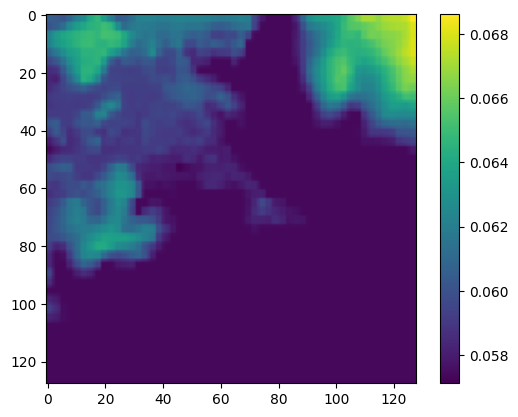

In [54]:
# Try to load one of the saved files to see if everything is working
#filepath = ELEVATION_ARRAY_DIR / f"{example_row.uid}.npy"
filepath = ELEVATION_ARRAY_DIR / f"aabm.npy"
loaded_layer = np.load(filepath)
plt.imshow((loaded_layer),cmap='viridis')
plt.colorbar()
plt.show()


# ***

## Extracting Features

In [55]:
# get path to the data folder
DATA_DIR = Path.cwd().parent.resolve() / "data"
assert DATA_DIR.exists()

In [56]:
# read dataset from csv file
df = pd.read_csv(DATA_DIR / "metadata.csv", parse_dates=["date"])
df.head()

uid   latitude   longitude       date  split
0  aabm  39.080319  -86.430867 2018-05-14  train
1  aabn  36.559700 -121.510000 2016-08-31   test
2  aacd  35.875083  -78.878434 2020-11-19  train
3  aaee  35.487000  -79.062133 2016-08-24  train
4  aaff  38.049471  -99.827001 2019-07-23  train

In [57]:
df = dataset.copy()

In [58]:
# add filepaths to dataframe
def get_path(id):
   return str(DATA_DIR/'elevation/elevation_1280_tiles/') + f"/{id}.npy"

df['path'] = df["uid"].apply(get_path)

In [59]:
df.head()

uid   latitude  longitude        date  split   region  severity  \
0  aabm  39.080319 -86.430867  2018-05-14  train  midwest         1   
1  aacd  35.875083 -78.878434  2020-11-19  train    south         1   
2  aaee  35.487000 -79.062133  2016-08-24  train    south         1   
3  aaff  38.049471 -99.827001  2019-07-23  train  midwest         3   
4  aafl  39.474744 -86.898353  2021-08-23  train  midwest         4   

     density                                               path  
0      585.0  /Users/marjangoudarzi/Neuefische/tick-tick-blo...  
1      290.0  /Users/marjangoudarzi/Neuefische/tick-tick-blo...  
2     1614.0  /Users/marjangoudarzi/Neuefische/tick-tick-blo...  
3   111825.0  /Users/marjangoudarzi/Neuefische/tick-tick-blo...  
4  2017313.0  /Users/marjangoudarzi/Neuefische/tick-tick-blo...

In [60]:

# function to calculate elevation features
def get_elevation_features(elevation_grid):
    elev_mean   = np.mean(elevation_grid)
    elev_median = np.median(elevation_grid)
    elev_min    = np.min(elevation_grid)
    elev_max    = np.max(elevation_grid)
    features = {'elev_mean':   elev_mean,
                'elev_median': elev_median,
                'elev_min':    elev_min, 
                'elev_max':    elev_max}
    return features

In [61]:
# process all elevation files
for row in tqdm(df.itertuples(), total=len(df)):
    # load elevation file
    elevation_grid = np.load(row.path)
    # extract features
    features = get_elevation_features(elevation_grid)
    # add features to dataframe
    df.loc[df['uid'] == row.uid, ['elev_mean']] = features['elev_mean']
    df.loc[df['uid'] == row.uid, ['elev_median']] = features['elev_median']
    df.loc[df['uid'] == row.uid, ['elev_min']] = features['elev_min']
    df.loc[df['uid'] == row.uid, ['elev_max']] = features['elev_max']


100%|██████████| 17060/17060 [01:21<00:00, 209.03it/s]


In [62]:
df = df.drop('path', axis=1)

In [63]:
df.head()

uid   latitude  longitude        date  split   region  severity  \
0  aabm  39.080319 -86.430867  2018-05-14  train  midwest         1   
1  aacd  35.875083 -78.878434  2020-11-19  train    south         1   
2  aaee  35.487000 -79.062133  2016-08-24  train    south         1   
3  aaff  38.049471 -99.827001  2019-07-23  train  midwest         3   
4  aafl  39.474744 -86.898353  2021-08-23  train  midwest         4   

     density  elev_mean  elev_median  elev_min  elev_max  
0      585.0   0.058860     0.057391  0.057125  0.068623  
1      290.0   0.044726     0.044747  0.039996  0.048706  
2     1614.0   0.050598     0.050579  0.043481  0.056447  
3   111825.0   0.174059     0.173836  0.171177  0.178763  
4  2017313.0   0.066571     0.065109  0.065109  0.078415

In [64]:
# save elevation features to csv file
#df.to_csv(DATA_DIR / "elevation.csv", index=False)